In [1]:
import pandas as pd
import numpy as np

# Cleaning SAbDab processed by Clint
Applying the following filtering:
* Removal of low quality antibodies based on Clint's label
* Removal of repeated peptides and DNA/RNA antigens
* Removal of signal peptides with SignalP

In [2]:
sabdab = pd.read_excel('sabdab_for_perry_240301.xlsx')
sabdab.shape

(2693, 12)

In [3]:
sabdab.columns

Index(['PDB-ID_HC_LC_AG', 'HV', 'HJ', 'CDRH3', 'HC_AA', 'HC_QUALITY_CHECK',
       'LV', 'LJ', 'CDRL3', 'LC_AA', 'LC_QUALITY_CHECK', 'AG_AA'],
      dtype='object')

In [4]:
sabdab = sabdab[sabdab['HC_QUALITY_CHECK'] == True]
print(sabdab.shape)

sabdab = sabdab[sabdab['LC_QUALITY_CHECK'] == True]
print(sabdab.shape)

(2685, 12)
(2629, 12)


In [5]:
## Removing short repeated peptides and DNA/RNA
repeated_peptides = (sabdab[sabdab['AG_AA'].apply(lambda x: len(np.unique(list(x))) <= 6)]['AG_AA']).index
print(len(repeated_peptides))

sabdab.drop(repeated_peptides, inplace=True)

96


Will need to remove these, but should remove tags first

In [6]:
sabdab[(sabdab['AG_AA'] + sabdab['HC_AA'] + sabdab['LC_AA']).apply(len) > 1024].shape

(353, 12)

In [7]:
# sabdab.to_csv('sabdab_CH_filtered_v1_24-03-01.csv')

In [8]:
antigens = sabdab[['PDB-ID_HC_LC_AG','AG_AA']]

In [10]:
# antigens = sabdab[['PDB-ID_HC_LC_AG','AG_AA']]


# # SignalP can only process <1000 proteins at a time
# df1 = antigens.iloc[range(0,900)]
# df2 = antigens.iloc[range(900,1800)]
# df3 = antigens.drop(np.concatenate([df1.index, df2.index]))


# with open('sabdab_antigens_for_SignalP-part1_24-03-12.fasta', 'w') as file:
#     for i,row in df1.iterrows():
#         file.write('>' + row['PDB-ID_HC_LC_AG'] + '\n')
#         file.write(row['AG_AA'] + '\n')

# file.close()

# with open('sabdab_antigens_for_SignalP-part2_24-03-12.fasta', 'w') as file:
#     for i,row in df2.iterrows():
#         file.write('>' + row['PDB-ID_HC_LC_AG'] + '\n')
#         file.write(row['AG_AA'] + '\n')

# file.close()

# with open('sabdab_antigens_for_SignalP-part3_24-03-12.fasta', 'w') as file:
#     for i,row in df3.iterrows():
#         file.write('>' + row['PDB-ID_HC_LC_AG'] + '\n')
#         file.write(row['AG_AA'] + '\n')

# file.close()

In [11]:
import os
signalP_dir = './signalP/'
signalP_outputs = [i for i in os.listdir(signalP_dir) if i.endswith('.txt')]

In [12]:
### SignalP output

signalP_output = pd.concat([pd.read_csv(signalP_dir + output, sep='\t', header=1, index_col=0) for output in signalP_outputs])
# summary_part1 = pd.read_csv('prediction_results_v1.txt', sep='\t', header=1, index_col=0)
signalP_output = signalP_output[signalP_output['Prediction'] != 'OTHER']
print(signalP_output.shape)

signalP_output['Pos'] = signalP_output['CS Position'].apply(lambda x: x.split('CS pos: ')[1].split('.')[0])
signalP_output['Prob'] = signalP_output['CS Position'].apply(lambda x: float(x.split('Pr: ')[1]))

# Only keep high probability
signalP_output = signalP_output[signalP_output['Prob'] >= 0.9]
print(signalP_output.shape)


(382, 8)
(344, 10)


<Axes: xlabel='Prob', ylabel='Count'>

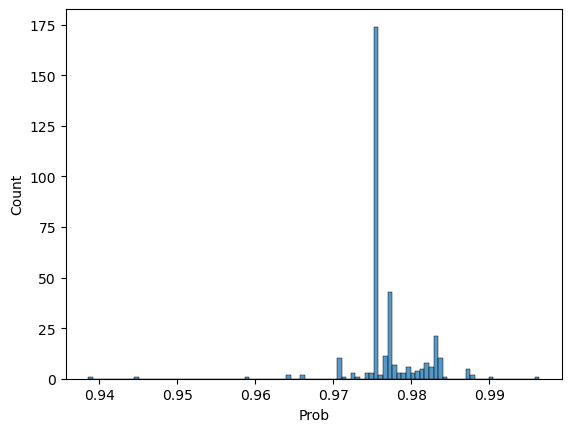

In [13]:
import seaborn as sns

sns.histplot(signalP_output['Prob'])

In [14]:
signalP_output.head()

,Prediction,OTHER,SP(Sec/SPI),LIPO(Sec/SPII),TAT(Tat/SPI),TATLIPO(Tat/SPII),PILIN(Sec/SPIII),CS Position,Pos,Prob
# ID,,,,,,,,,,
6VGR_C_D_A,SP,0.000313,0.998890,0.000222,0.000220,0.000175,0.000166,CS pos: 36-37. Pr: 0.9662,36-37,0.9662
7KRA_I_J_A,SP,0.000152,0.999348,0.000132,0.000146,0.000116,0.000116,CS pos: 24-25. Pr: 0.9808,24-25,0.9808
8JHC_H_L_R,SP,0.000155,0.999329,0.000132,0.000142,0.000115,0.000116,CS pos: 16-17. Pr: 0.9744,16-17,0.9744
8JH7_H_L_D,SP,0.000169,0.999260,0.000148,0.000158,0.000128,0.000133,CS pos: 16-17. Pr: 0.9748,16-17,0.9748
7KEJ_G_J_A,SP,0.000153,0.999357,0.000129,0.000144,0.000118,0.000117,CS pos: 22-23. Pr: 0.9871,22-23,0.9871


In [14]:
sabdab.index = sabdab['PDB-ID_HC_LC_AG']

Should probably remove leucine repeats here as well: \
https://pubmed.ncbi.nlm.nih.gov/20561057/#:~:text=In%20the%20human%20proteome%2C%20although,chain%20and%20then%20degraded%20rapidly.

In [15]:
sabdab['AG_AA'].iloc[2]

'MQPTGREGSRALSRRYLRRLLLLLLLLLLRQPVTRAETTPGAPRALSTLGSPSLFTTPGVPSALTTPGLTTPGTPKTLDLRGRAQALMRSFPLVDGHNDLPQVLRQRYKNVLQDVNLRNFSHGQTSLDRLRDGLVGAQFWSASVSCQSQDQTAVRLALEQIDLIHRMCASYSELELVTSAEGLNSSQKLACLIGVEGGHSLDSSLSVLRSFYVLGVRYLTLTFTCSTPWAESSTKFRHHMYTNVSGLTSFGEKVVEELNRLGMMIDLSYASDTLIRRVLEVSQAPVIFSHSAARAVCDNLLNVPDDILQLLKKNGGIVMVTLSMGVLQCNLLANVSTVADHFDHIRAVIGSEFIGIGGNYDGTGRFPQGLEDVSTYPVLIEELLSRSWSEEELQGVLRGNLLRVFRQVEKVREESRAQSPVEAEFPYGQLSTSCHSHLVPQNGHQATHLEVTKQPTNRVPWRSSNASPYLVPGLVAAATIPTFTQWLC'

In [16]:
def get_signalP(row):

    antigen_seq = row['full_antigen']
    index = row.name
    cleave_pos = int(row['Pos'].split('-')[1])

    signal_peptide = antigen_seq[0:cleave_pos]

    return signal_peptide
    

In [17]:
signalP_output['full_antigen'] = sabdab['AG_AA']

In [18]:
signalP_output = signalP_output.loc[(np.intersect1d(sabdab.index, signalP_output.index))]

In [19]:
signalP_output['signal_peptide'] = signalP_output.apply(get_signalP, axis=1)

In [21]:
signalP_output['signal_peptide'].value_counts()

MFVFLVLLPLVSSQ                             214
MELLILKANAITTILTAVTFCFASGQ                   9
MGILPSPGMPALLSLVSLLSVLLMGCVAE                9
MSWKVVIIFSLLITPQHGL                          7
METDTLLLWVLLLWVPGSTGD                        7
MAIIYLILLFTAVRGD                             5
MDAMKRGLCCVLLLCGAVFVSPS                      5
MFVFLVLLPLVSIQ                               3
MPMGSLQPLATLYLLGMLVASVLAV                    3
MLLVNQSHQGFNKEHTSKMVSAIVLYVLLAAAAHSAFAA      3
MKTIIALSYIFCLVFAD                            3
MKVKLLVLLCTFTATYAG                           3
MPMGSLQPLATLYLLGMLVASVLAA                    2
MSWKVMIIISLLITPQHGL                          2
MVLVNQSHQGFNKEHTSKMVSAIVLYVLLAAAAHSAFAG      2
MVLVNQSHQGFNKEHTSKMVSAIVLYVLLAAAAHSAFAA      2
MIHSVFLLMFLLTPTESY                           2
MARAWIFFLLCLAGRALAR                          2
MELAALCRWGLLLALLPPGAAST                      2
MTPGKTSLVSLLLLLSLEAIVKAG                     2
MWLQSLLLLGTVACSISA                           2
MKWVTFISLLFLF

In [144]:
signalP_output['clean_antigen'] = signalP_output.apply(lambda x: x['full_antigen'].replace(x['signal_peptide'], ''), axis=1)

In [145]:
cleaned_dict = dict(zip(signalP_output['full_antigen'], signalP_output['clean_antigen']))

In [146]:
## Mapping cleaned antigens into SAbDAb df

sabdab['antigen_noSignalP'] = sabdab['AG_AA'].replace(cleaned_dict)

assert sabdab['antigen_noSignalP'].isna().sum() == 0

In [147]:
sabdab.columns

Index(['PDB-ID_HC_LC_AG', 'HV', 'HJ', 'CDRH3', 'HC_AA', 'HC_QUALITY_CHECK',
       'LV', 'LJ', 'CDRL3', 'LC_AA', 'LC_QUALITY_CHECK', 'AG_AA',
       'antigen_noSignalP'],
      dtype='object')

In [149]:
sabdab.to_csv('sabdab_CH_filtered_v1_24-03-04.csv')